# Tutorial on using the classes for transpiling DBQA strategies into various types of double-bracket rotations (DBRs)

## 1. VQE results are loaded
## 2. The GC3 DBR is shown using explicit circuits obtained from more basic and special purpose functions
## 3. The same is done using the `GroupCommutatorIterationWithEvolutionOracles` class
### 3.1. It is shown how to perform more steps of the GCI. 
Using the class approach one can just change `mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced` to a different type and same code will run.

In [1]:
import json
import time
from pathlib import Path

import numpy as np
import qibo
from qibo import hamiltonians, set_backend
from boostvqe.models.dbi.double_bracket import (
    DoubleBracketGeneratorType,
    DoubleBracketIteration,
)

from boostvqe.ansatze import VQE, build_circuit
from boostvqe.utils import apply_dbi_steps, rotate_h_with_vqe
from qibo import symbols, hamiltonians
from copy import deepcopy
from boostvqe.compiling_XXZ import *

import matplotlib.pyplot as plt

## 1. Loading VQE results

In [2]:

qibo.set_backend("numpy")

# set the path string which define the results
path = "../results/vqe_data/with_params/10q3l/sgd_10q_3l_42/"

# set the target epoch to which apply DBQA and the number of steps
target_epoch = 2000
dbi_steps = 1

# upload system configuration and parameters for all the training
with open(path + "optimization_results.json") as file:
    config = json.load(file)

losses = dict(np.load(path + "energies.npz"))["0"]
params = np.load(path + f"parameters/params_ite{target_epoch}.npy")

nqubits = config["nqubits"]
# build circuit, hamiltonian and VQE
hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)
circuit = build_circuit(nqubits, config["nlayers"], "numpy")
vqe = VQE(circuit, hamiltonian)
zero_state = hamiltonian.backend.zero_state(nqubits)
zero_state_t = np.transpose([zero_state])
target_energy = np.min(hamiltonian.eigenvalues())


# set target parameters into the VQE
vqe.circuit.set_parameters(params)
vqe_state = vqe.circuit().state()

ene1 = hamiltonian.expectation(vqe_state)


[Qibo 0.2.9|INFO|2024-06-12 22:15:44]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0
[Qibo 0.2.9|INFO|2024-06-12 22:15:44]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In the VQE numpy


In [3]:
print(f"VQE energy is {ene1}. \n\
The target energy is {target_energy} which means the difference is {ene1-target_energy}.\n\
The relative difference is {abs(ene1-target_energy)/abs(target_energy)}%.")

VQE energy is -14.560174594055583. 
The target energy is -15.276131122065795 which means the difference is 0.7159565280102118.
The relative difference is 0.04686766055418572%.


# 2. try gradient descent
$D= \sum_i B_i Z_i$
and Group commutator

In [4]:
b_list = [1+x+np.sin(i) for i,x in enumerate(np.random.rand(10)) ]
j_list = [1]* nqubits**2
#b_list = np.random.rand(nqubits)
zz_terms = []
for j in range( nqubits):
    for k in range(j+1,nqubits):
        zz_terms.append(-symbols.Z(j)*symbols.Z(k))
len(zz_terms) - nqubits*(nqubits-1)/2


0.0

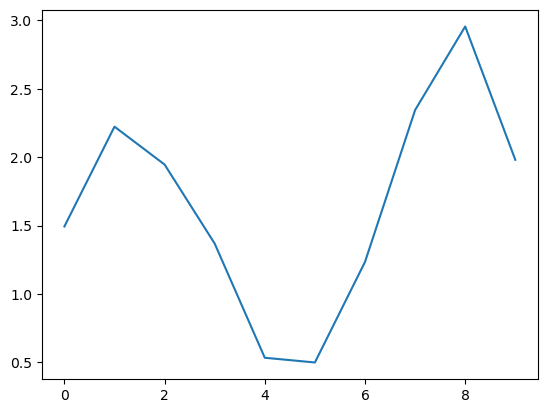

In [5]:
d = hamiltonians.SymbolicHamiltonian( sum([b*symbols.Z(j)*symbols.Z(0) for j,b in zip(range(nqubits),b_list)]\
                                           + [symbols.Z(j)*symbols.Z(j+1) for j in range (nqubits-1)]))

plt.plot(b_list)

In [6]:


from boostvqe.models.dbi.group_commutator_iteration_transpiler import *
from boostvqe.models.dbi.double_bracket_evolution_oracles import *

# quick hack how to use the method function hamiltonians.XXZ to get a simulable oracle
hamiltonian.delta = 0.5
hamiltonian.dense = hamiltonian
eo_xxz = XXZ_EvolutionOracle(hamiltonian,mode_evolution_oracle=EvolutionOracleType.numerical, steps = 1, order = 2)
eo_xxz.mode_evolution_oracle=EvolutionOracleType.hamiltonian_simulation
#hack end

# prescribe nmb of steps, otherwise there will be casting to dense and searching for a step duration (this can later be avoided with @shangtai non-classical simulation PR)
eo_xxz.please_use_prescribed_nmb_ts_steps = 1

# implement the rotate by VQE on the level of circuits
fsoe  = FrameShiftedEvolutionOracle(eo_xxz, before_circuit=vqe.circuit.invert(), 
                                                        after_circuit=vqe.circuit,name="shifting by vqe")

# init gci with the vqe-rotated hamiltonian
gci  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced)
gci.h_ref = deepcopy(hamiltonian)
# init the generator of the evolution,
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
eo_d = EvolutionOracle(d,mode_evolution_oracle=EvolutionOracleType.hamiltonian_simulation,name = "D(linear)")
eo_d.please_use_prescribed_nmb_ts_steps = 1
step,loss = gci.choose_step(d = eo_d,max_evals=14)
# above we didn't gauge the time \approx e^{x^2 [D,H]} but gci approximates e^{-sW} so takes a square root
circ_boost = (  gci.group_commutator(step, eo_d)["forwards"] +vqe.circuit )

hamiltonian.expectation(circ_boost().state()) 

-14.774082591517226

In [7]:
def gradient_numerical_circuits(
    dbi_object: DoubleBracketIteration,
    d_params: list,
    parameterization: ParameterizationTypes,
    s: float = 1e-2,
    delta: float = 1e-3,
    backend=None,
    loss_0 = None,
    **kwargs,
):
    r"""
    Gradient of the DBI with respect to the parametrization of D. A simple finite difference is used to calculate the gradient.

    Args:
        dbi_object (DoubleBracketIteration): DoubleBracketIteration object.
        d_params (np.array): Parameters for the ansatz (note that the dimension must be 2**nqubits for full ansazt and nqubits for Pauli ansatz).
        s (float): A short flow duration for finding the numerical gradient.
        delta (float): Step size for numerical gradient.
    Returns:
        grad (np.array): Gradient of the D operator.
    """

    nqubits = dbi_object.nqubits
    grad = np.zeros(len(d_params))
    d = params_to_diagonal_operator(
        d_params, nqubits, parameterization=parameterization, **kwargs
    )
    if loss_0 is None:
        loss_0 = dbi_object.loss(s, d)
    for i in range(len(d_params)):
        params_new = deepcopy(d_params)
        params_new[i] += delta
        d_new = params_to_diagonal_operator(
            params_new, nqubits, parameterization=parameterization, **kwargs
        )
        # find the increment of a very small step
        grad[i] = (dbi_object.loss(s, d_new) - loss_0 ) / delta
    return grad

In [8]:
params_init = b_list+np.random.rand(len(zz_terms)).tolist()
grad = gradient_numerical_circuits(
    gci,
    params_init,
    ParameterizationTypes.circuits,
    s=1e-4
)

In [9]:
grad

array([-0.00023143, -0.00028476, -0.00030681, -0.00033978, -0.00030483,
       -0.0002092 , -0.00031248, -0.00038237, -0.00025515, -0.00024369,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [10]:
def params_to_diagonal_operator_ising(
            d_params_test,
            nqubits
        ):
    b_list = d_params_test[:nqubits]
    j_couplings = d_params_test[nqubits:]
    d = hamiltonians.SymbolicHamiltonian( sum([b*symbols.Z(j)*symbols.Z(0) for j,b in zip(range(nqubits),b_list)]\
                                               + [j*zz for j,zz in zip(j_couplings,zz_terms)]))
    return EvolutionOracle(d,mode_evolution_oracle=EvolutionOracleType.hamiltonian_simulation,name = "D(linear)")
eo_dd = params_to_diagonal_operator_ising(params_init,10)    


In [11]:
def gradient_descent_circuits(
    dbi_object: DoubleBracketIteration,
    train_epochs: int,
    d_params_init: list,
    lr: float = 1e-2,
    step_guess = 0.01
):

    nqubits = dbi_object.nqubits

    d_params_store = []
    s_store = []
    loss_store = []


    d_init = params_to_diagonal_operator(
                d_params_init,
                nqubits,
                parameterization=ParameterizationTypes.circuits
            )
    s,loss = dbi_object.choose_step(d = eo_d,step_min=0.0001,step_max=1.15*0.01, max_evals=25)
    print(loss)
    d_params_test = d_params_init
    for i in range(train_epochs):
        print(i)
        # find gradient
        grad = gradient_numerical_circuits(
            dbi_object,
            d_params_test,
            ParameterizationTypes.circuits,
            s=s,
            loss_0 = loss
        )
        d_params_test = [d_params_init[j] - grad[j] * lr for j in range(len(grad))]
        d = params_to_diagonal_operator(
            d_params_test,
            nqubits,
            parameterization=ParameterizationTypes.circuits
        )
        step_guess, loss = dbi_object.choose_step(d=d,step_min=1e-3,step_max=0.02, max_evals=35,verbose=False)
        print(loss)
        d_params_store.append(d_params_test)
        s_store.append(step_guess)
        loss_store.append(loss)

    min_loss = min(loss_store)
    idx_min = loss_store.index(min_loss)
    d_params_test = d_params_store[idx_min]
    s = s_store[idx_min]

    return d_params_test, s, min_loss

In [15]:
d_params_test, s, min_loss = gradient_descent_circuits(
gci,
 train_epochs=10,
   d_params_init=b_list,
   lr=.01
)

-14.774572132257937
0
-14.764671527966495
1
-14.765265268306193
2
-14.765423375098516
3


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x75302dee2f60>>
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


-14.765460537403778
4


In [ ]:
np.max(np.array(d_params_test) - np.array(b_list))

0.18170436817399604

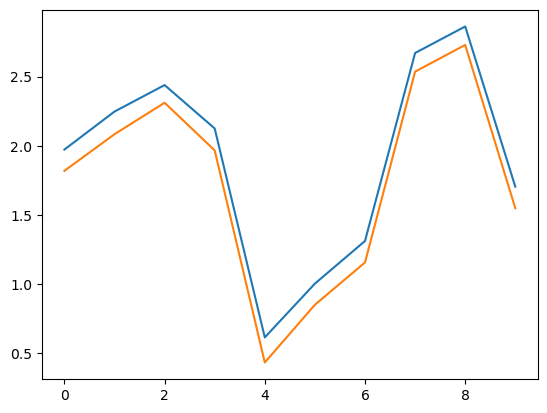

In [ ]:
plt.plot(d_params_test)
plt.plot(b_list)

In [ ]:
step,loss = gci.choose_step(d = eo_d,step_min=0.0001,step_max=1.15*0.01, max_evals=25)

In [ ]:
loss

-14.768452279524393

In [ ]:
step

0.010549999999999999

In [ ]:
step,loss = gci.choose_step(d = params_to_diagonal_operator(
            d_params_test,
            nqubits,
            parameterization=ParameterizationTypes.circuits
        ),step_min=0.0001,step_max=1.15*0.01, max_evals=25)

In [ ]:
loss

-14.770140671684798

In [ ]:
m = params_to_diagonal_operator(
            d_params_test,
            nqubits,
            parameterization=ParameterizationTypes.circuits
        ).h.dense.matrix

[Qibo 0.2.9|WARNING|2024-06-12 21:45:12]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [ ]:
D = np.diag(m)

In [ ]:
hvqe_matrix = rotate_h_with_vqe(hamiltonian=hamiltonian, vqe=vqe)

In [ ]:
Dvqe = np.diag(hvqe_matrix)

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


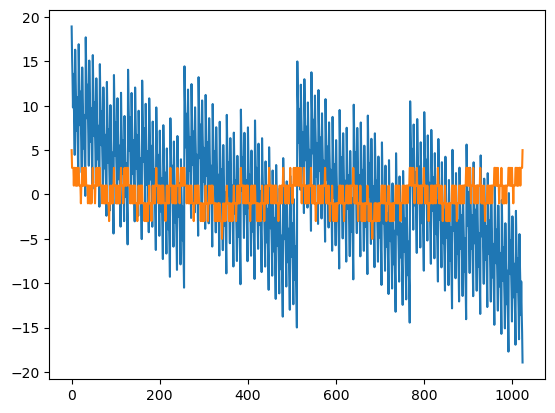

In [ ]:
plt.plot(D)
plt.plot(Dvqe)

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


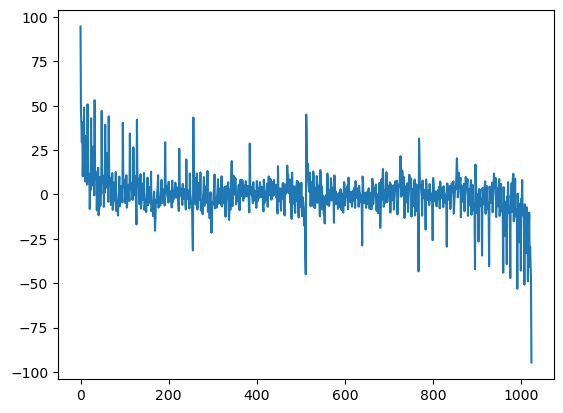

In [ ]:
plt.plot([x*y for x,y in zip(Dvqe,D)])

In [ ]:
np.sum([x*y for x,y in zip(Dvqe,D)])

(2.2737367544323206e-13+0j)

In [ ]:

hvqe_matrix.shape


(1024, 1024)

In [ ]:
SymbolicHamiltonian(symbols.Z(0),nqubits=nqubits).dense.matrix.shape

[Qibo 0.2.9|WARNING|2024-06-12 21:51:35]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


(1024, 1024)

In [ ]:
for i in range(nqubits):
    print(np.trace(hvqe_matrix@(SymbolicHamiltonian(symbols.Z(i)*symbols.Z(0),nqubits=nqubits).dense.matrix)))

[Qibo 0.2.9|WARNING|2024-06-12 21:53:28]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.9|WARNING|2024-06-12 21:53:34]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-12 21:53:39]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


(512+0j)


[Qibo 0.2.9|WARNING|2024-06-12 21:53:45]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-12 21:53:50]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-12 21:53:56]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-12 21:54:01]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-12 21:54:08]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-12 21:54:14]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-12 21:54:20]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j
